# 🎓 UAS Natural Language Processing: Topic Modeling

---

| Informasi | Detail |
|-----------|--------|
| **Nama** | Josia Given Santoso |
| **NIM** | 36230035 |
| **Mata Kuliah** | DSF06 – Natural Language Processing |
| **Kelas** | 5PDS3 |
| **Dataset** | Blog Authorship Corpus (Kaggle) |
| **Spesifikasi Hardware** | **Intel Core i5 12450H (8 Core, 12 Thread), RAM 32GB** |
| **Tanggal** | Desember 2025 |

---

## 📋 Deskripsi Proyek

Proyek ini bertujuan untuk melakukan **Topic Modeling** pada dataset Blog Authorship Corpus yang berisi sekitar **681.000 dokumen** blog. Kita akan menggunakan teknik unsupervised learning untuk menemukan topik atau tema tersembunyi dalam korpus teks.

Notebook ini telah dioptimalkan untuk efisiensi memori dan kecepatan eksekusi pada hardware yang ditentukan.

### Model yang Digunakan:
1. **LSA (Latent Semantic Analysis)** - Pendekatan dimensionality reduction (Full Dataset).
2. **LDA (Latent Dirichlet Allocation)** - Model generatif probabilistik (Mini-Batch Optimized).
3. **NMF (Non-negative Matrix Factorization)** - Faktorisasi matriks non-negatif (Mini-Batch Optimized).
4. **BERTopic** - Model berbasis Transformer (State-of-the-art, Sampled).

### Pipeline:
```
Data Acquisition → Data Understanding → EDA → Preprocessing → Vectorization → Modeling → Evaluation → Analysis
```


In [24]:
# Core libraries
import os
import re
import warnings
import time
from pathlib import Path
from collections import Counter
import multiprocessing
import gc
import sys
import random

# Data handling
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

# NLP
import nltk
from nltk.corpus import stopwords
import spacy

# ML & Topic Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, MiniBatchNMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# Gensim
import gensim
from gensim import corpora
from gensim.models import LdaMulticore, CoherenceModel

# BERTopic
try:
    from bertopic import BERTopic
    from umap import UMAP
    from hdbscan import HDBSCAN
except ImportError:
    print("BERTopic libraries not found. Some sections may not run.")

# Dataset download
import kagglehub

# Config
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# NLTK downloads
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("All libraries imported successfully.")


All libraries imported successfully.


In [25]:
# Load SpaCy model
try:
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    print("SpaCy model 'en_core_web_sm' loaded successfully.")
except OSError:
    print("Downloading SpaCy model...")
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    print("SpaCy model downloaded and loaded.")


SpaCy model 'en_core_web_sm' loaded successfully.


In [26]:
# Path configuration
BASE_DIR = Path().resolve().parent
DATASET_DIR = BASE_DIR / 'datasets'
DATASET_DIR.mkdir(exist_ok=True)

PARQUET_PATH = DATASET_DIR / 'blog_corpus.parquet'

print(f"Base Directory: {BASE_DIR}")
print(f"Dataset Directory: {DATASET_DIR}")


Base Directory: D:\Dev_Drive\Coding Project Files\Uni_Assignment\UAS\36230035_NLP_UAS
Dataset Directory: D:\Dev_Drive\Coding Project Files\Uni_Assignment\UAS\36230035_NLP_UAS\datasets


---
## 2. Data Acquisition (Pengambilan Data)

Dataset **Blog Authorship Corpus** diunduh dari Kaggle. Karena ukuran dataset yang besar, data dikonversi ke format **Parquet** untuk efisiensi pembacaan dan penggunaan memori.

### Strategi Optimasi:
- **Parquet Format**: Kompresi Snappy untuk mengurangi ukuran file dan mempercepat I/O.
- **Chunk Processing**: Membaca CSV dalam potongan-potongan kecil untuk menghindari MemoryError.


In [27]:
# Download dataset from Kaggle
if not PARQUET_PATH.exists():
    print("Downloading dataset from Kaggle...")
    try:
        kaggle_path = kagglehub.dataset_download("rtatman/blog-authorship-corpus")
        print(f"Dataset downloaded to: {kaggle_path}")
        
        # Find CSV file
        csv_files = list(Path(kaggle_path).glob('*.csv'))
        if csv_files:
            csv_path = csv_files[0]
            print(f"Found CSV: {csv_path}")
        else:
            raise FileNotFoundError("CSV file not found in downloaded dataset.")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        csv_path = None
else:
    print(f"Parquet file already exists: {PARQUET_PATH}")
    csv_path = None

# Convert CSV to Parquet (one-time operation)
if csv_path and not PARQUET_PATH.exists():
    print("Converting CSV to Parquet (this may take a while)...")
    
    # Read in chunks for memory efficiency
    chunk_size = 100000
    chunks = []
    
    try:
        for i, chunk in enumerate(pd.read_csv(csv_path, chunksize=chunk_size, 
                                              encoding='latin-1', on_bad_lines='skip')):
            chunks.append(chunk)
            print(f"  Chunk {i+1} loaded: {len(chunk)} rows")
        
        # Combine and save
        df_full = pd.concat(chunks, ignore_index=True)
        print(f"Total rows: {len(df_full):,}")
        
        # Save to parquet
        df_full.to_parquet(PARQUET_PATH, engine='pyarrow', compression='snappy')
        print(f"Data saved to: {PARQUET_PATH}")
        
        # Clean up
        del chunks, df_full
        gc.collect()
    except Exception as e:
        print(f"Error converting to parquet: {e}")
else:
    print("Parquet file ready.")


Parquet file already exists: D:\Dev_Drive\Coding Project Files\Uni_Assignment\UAS\36230035_NLP_UAS\datasets\blog_corpus.parquet
Parquet file ready.


---
## 3. Data Loading dengan Dask

Menggunakan **Dask** untuk memuat dataset. Dask memungkinkan operasi *lazy evaluation* yang sangat berguna untuk dataset besar.


In [28]:
# Load with Dask
print("Loading data with Dask...")
ddf = dd.read_parquet(PARQUET_PATH)

print("Dask DataFrame Info:")
print(f"  Partitions: {ddf.npartitions}")
print(f"  Columns: {list(ddf.columns)}")

# Compute basic stats
with ProgressBar():
    n_rows = len(ddf)
    
print(f"Total Documents: {n_rows:,}")

# Sample for initial exploration
print("Sample data (first 5 rows):")
df_sample = ddf.head(5)
display(df_sample)


Loading data with Dask...
Dask DataFrame Info:
  Partitions: 1
  Columns: ['id', 'gender', 'age', 'topic', 'sign', 'date', 'text']
[########################################] | 100% Completed | 105.48 ms
Total Documents: 681,284
Sample data (first 5 rows):


,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait unti..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewes van der Laag urlLink mail Ruiyu Xie ...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde: MAAK JE EIGEN WATERSTOFBOM How to build an H-...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can now 'capture' the URLs of popups...which means now...


---
## 4. Data Understanding (Pemahaman Data)

Analisis struktur dan kualitas data sebelum pemrosesan lebih lanjut. Output di bawah ini ditampilkan dalam Bahasa Inggris untuk konsistensi laporan teknis.


In [29]:
# 4.1 Dataset Structure
print("="*60)
print("4.1 DATASET STRUCTURE")
print("="*60)

# Convert sample to pandas for detailed analysis
df = ddf.compute()
print(f"Dataset Dimensions: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i}. {col}")

print(f"Data Types:")
print(df.dtypes)

# 4.2 Missing Values Analysis
print("\n" + "="*60)
print("4.2 MISSING VALUES ANALYSIS")
print("="*60)

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
})
print(missing_df.to_string(index=False))

print(f"Conclusion: Dataset is {'CLEAN' if missing.sum() == 0 else 'containing missing values'}")

# 4.3 Cardinality Analysis
print("\n" + "="*60)
print("4.3 CARDINALITY ANALYSIS")
print("="*60)

for col in df.columns:
    if col == 'text':
        unique_count = df[col].sample(min(50000, len(df))).nunique()
        print(f"  {col}: ~{unique_count:,} unique values (estimated)")
    else:
        unique_count = df[col].nunique()
        print(f"  {col}: {unique_count:,} unique values")

# 4.4 Document Length Statistics
print("\n" + "="*60)
print("4.4 DOCUMENT LENGTH STATISTICS")
print("="*60)

SAMPLE_SIZE = 50000
df_stats = df.sample(min(SAMPLE_SIZE, len(df)), random_state=42).copy()
df_stats['word_count'] = df_stats['text'].fillna('').apply(lambda x: len(str(x).split()))

print(df_stats[['word_count']].describe())

# 4.5 Language Analysis
print("\n" + "="*60)
print("4.5 LANGUAGE STYLES")
print("="*60)
print(f"Sample Text: '{df['text'].iloc[0][:200]}...'")
print("Styles: Informal, personal blog entries, likely containing noise like URLs.")


4.1 DATASET STRUCTURE
Dataset Dimensions: 681,284 rows x 7 columns
Columns:
   1. id
   2. gender
   3. age
   4. topic
   5. sign
   6. date
   7. text
Data Types:
id                  int64
gender    string[pyarrow]
age                 int64
topic     string[pyarrow]
sign      string[pyarrow]
date      string[pyarrow]
text      string[pyarrow]
dtype: object

4.2 MISSING VALUES ANALYSIS
Column  Missing Count  Missing %
    id              0        0.0
gender              0        0.0
   age              0        0.0
 topic              0        0.0
  sign              0        0.0
  date              0        0.0
  text              0        0.0
Conclusion: Dataset is CLEAN

4.3 CARDINALITY ANALYSIS
  id: 19,320 unique values
  gender: 2 unique values
  age: 26 unique values
  topic: 40 unique values
  sign: 12 unique values
  date: 2,616 unique values
  text: ~49,043 unique values (estimated)

4.4 DOCUMENT LENGTH STATISTICS
         word_count
count  50000.000000
mean     197.993540
s

---
## 5. Exploratory Data Analysis (EDA) - Visualisasi Awal

Visualisasi distribusi data mentah.


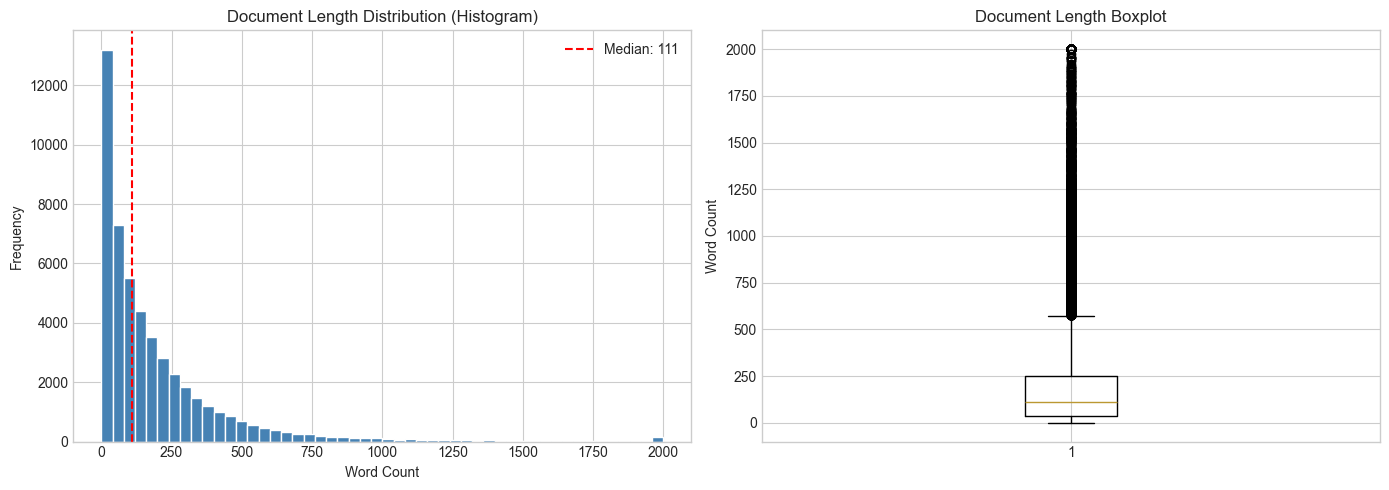

Generating Word Cloud for raw text...


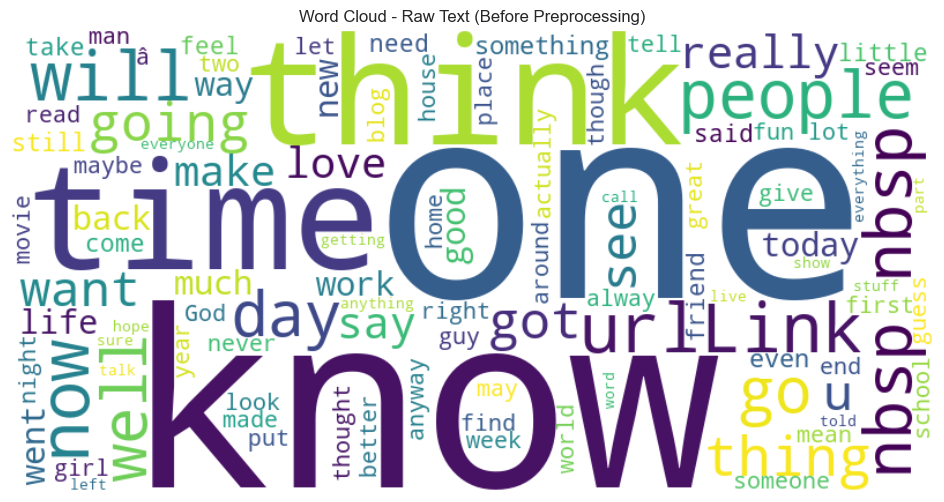

In [30]:
# 5.1 Document Length Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_stats['word_count'].clip(upper=2000), bins=50, color='steelblue', edgecolor='white')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Document Length Distribution (Histogram)')
axes[0].axvline(df_stats['word_count'].median(), color='red', linestyle='--', label=f'Median: {df_stats["word_count"].median():.0f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(df_stats['word_count'].clip(upper=2000), vert=True)
axes[1].set_ylabel('Word Count')
axes[1].set_title('Document Length Boxplot')

plt.tight_layout()
plt.show()

# 5.2 Word Cloud (Raw)
print("Generating Word Cloud for raw text...")
text_combined = ' '.join(df['text'].fillna('').sample(10000, random_state=42))
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text_combined)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Raw Text (Before Preprocessing)')
plt.show()


---
## 6. Text Preprocessing (Optimized)

Menggunakan modul terpisah dan `multiprocessing` untuk mempercepat pembersihan data ratusan ribu dokumen.

**Teknik yang digunakan:**
1. **Lowercasing**: Normalisasi huruf.
2. **URL/HTML Removal**: Membersihkan noise web.
3. **Contraction Expansion**: Mengubah "don't" mencjadi "do not".
4. **Lemmatization**: Menggunakan WordNetLemmatizer dengan LRU Cache.
5. **Short Document Filtering**: Menghapus dokumen < 5 kata.


In [31]:
# Create efficient preprocessing helper script to handle multiprocessing
# This avoids the "interactive interpreter" issues with multiprocessing on Windows
helper_content = """
import re
import html
import nltk
from functools import lru_cache
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Ensure resources
try:
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('wordnet', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('omw-1.4', quiet=True)

STOP_WORDS = set(stopwords.words('english'))
# Add common blog noise words
STOP_WORDS.update(['urlLink', 'urllink', 'nbsp', 'http', 'com'])
lemmatizer = WordNetLemmatizer()

# Contraction Map
CONTRACTIONS = {
    "ain't": "is not", "aren't": "is not", "can't": "cannot", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'll": "how will", "how's": "how is", "i'd": "i would",
    "i'll": "i will", "i'm": "i am", "i've": "i have", "isn't": "is not",
    "it'd": "it would", "it'll": "it will", "it's": "it is", "let's": "let us",
    "ma'am": "madam", "might've": "might have", "must've": "must have", "needn't": "need not",
    "shan't": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "that'd": "that would",
    "that's": "that is", "there'd": "there would", "there's": "there is", "they'd": "they would",
    "they'll": "they will", "they're": "they are", "they've": "they have",
    "wasn't": "was not", "we'd": "we would", "we'll": "we will", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what're": "what are",
    "what's": "what is", "what've": "what have", "where's": "where is", "who's": "who is",
    "who'll": "who will", "who've": "who have", "won't": "will not", "would've": "would have",
    "wouldn't": "would not", "y'all": "you all", "you'd": "you would", "you'll": "you will",
    "you're": "you are", "you've": "you have"
}

# Regex
re_url = re.compile(r'https?://\S+|www\.\S+')
re_html = re.compile(r'<.*?>')
re_alpha = re.compile(r'[^a-z\s]')
re_spaces = re.compile(r'\s+')

@lru_cache(maxsize=50000)
def cached_lemmatize(word):
    return lemmatizer.lemmatize(word)

def clean_text(text):
    if not isinstance(text, str):
        return ''
    
    # Decoding and Lowercase
    text = html.unescape(text).lower()
    
    # Remove URLs and HTML
    text = re_url.sub(' ', text)
    text = re_html.sub(' ', text)
    
    # Expand Contractions
    for k, v in CONTRACTIONS.items():
        if k in text:
            text = text.replace(k, v)
            
    # Keep only alphabets
    text = re_alpha.sub(' ', text)
    
    # Collapse spaces
    text = re_spaces.sub(' ', text).strip()
    return text

def process_batch(batch_texts):
    processed = []
    # Localize globals for speed loop
    local_stop = STOP_WORDS
    local_lem = cached_lemmatize
    
    for text in batch_texts:
        cleaned = clean_text(str(text))
        tokens = cleaned.split()
        final_tokens = [local_lem(w) for w in tokens if len(w) > 2 and w not in local_stop]
        processed.append(" ".join(final_tokens))
    return processed
"""

with open("preprocessing_helpers.py", "w") as f:
    f.write(helper_content)

if "preprocessing_helpers" in sys.modules:
    import importlib
    importlib.reload(sys.modules["preprocessing_helpers"])
else:
    import preprocessing_helpers

from preprocessing_helpers import process_batch
print("Preprocessing helper module loaded.")


Preprocessing helper module loaded.


In [32]:
# Run Preprocessing with Multiprocessing
# Generator to conserve RAM
def batch_generator(df, batch_size):
    total = len(df)
    for i in range(0, total, batch_size):
        yield df.iloc[i:i+batch_size]['text'].values.tolist()

if __name__ == '__main__':
    BATCH_SIZE = 10000 
    NUM_WORKERS = max(1, multiprocessing.cpu_count() - 2)
    
    print(f"Starting Preprocessing...")
    print(f"Workers: {NUM_WORKERS}")
    print(f"Batch Size: {BATCH_SIZE:,}")
    
    total_batches = (len(df) // BATCH_SIZE) + 1
    processed_texts = []
    
    # Use Pool
    with multiprocessing.Pool(processes=NUM_WORKERS) as pool:
        print("Processing batches (Please wait)...")
        from tqdm.notebook import tqdm
        
        # Wrapped in list to force execution if not using tqdm, but tqdm helps visibility
        # Note: In standard script, tqdm works. In notebook, it needs widget. 
        # Falling back to simple print if needed, but we use 'dask.ProgressBar' style via tqdm
        results = list(tqdm(pool.imap(process_batch, batch_generator(df, BATCH_SIZE)), total=total_batches, unit="batch"))
        
        for batch_res in results:
            processed_texts.extend(batch_res)
            
    # Assign back
    df_model = df.copy()
    df_model['text_processed'] = processed_texts
    
    print(f"Preprocessing complete. {len(df_model):,} documents processed.")
    
    # Cleanup
    del processed_texts, results
    gc.collect()


Starting Preprocessing...
Workers: 10
Batch Size: 10,000
Processing batches (Please wait)...


  0%|          | 0/69 [00:00<?, ?batch/s]

Preprocessing complete. 681,284 documents processed.


In [33]:
# Filter short documents
df_model['processed_word_count'] = df_model['text_processed'].str.split().str.len()

MIN_WORDS = 5
print(f"Filtering documents with less than {MIN_WORDS} words...")

initial_count = len(df_model)
df_model = df_model[df_model['processed_word_count'] >= MIN_WORDS].copy()
final_count = len(df_model)

print(f"Documents preserved: {final_count:,} ({final_count/initial_count*100:.2f}%)")
print(f"Documents removed: {initial_count - final_count:,}")


Filtering documents with less than 5 words...
Documents preserved: 627,839 (92.16%)
Documents removed: 53,445


---
## 7. EDA Setelah Preprocessing (English Charts)

Membandingkan kualitas data sebelum dan sesudah cleaning.


Generating Word Cloud for processed text...


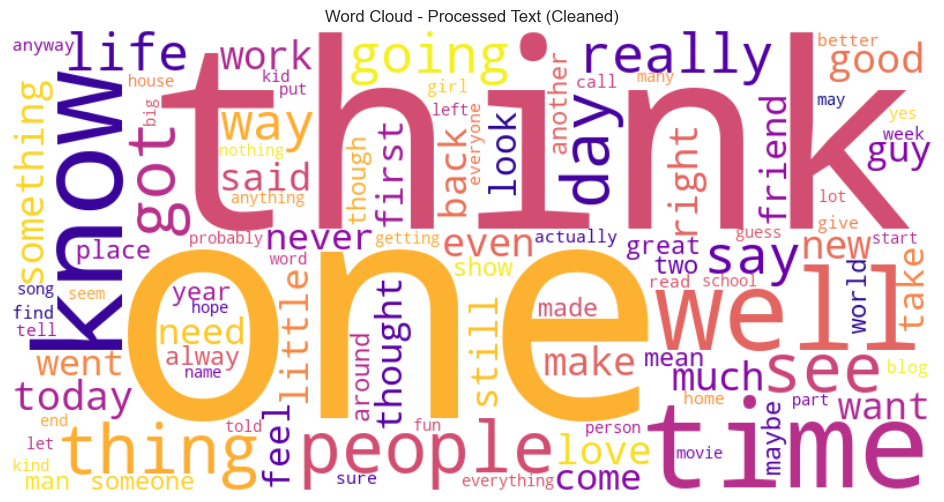

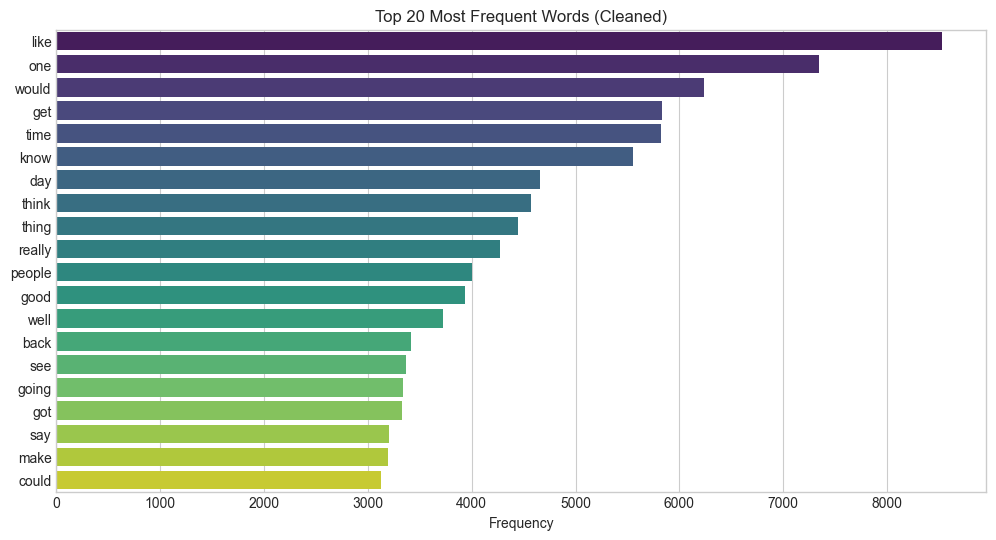

In [34]:
# 7.1 Word Cloud (Processed)
print("Generating Word Cloud for processed text...")
text_proc_combined = ' '.join(df_model['text_processed'].head(10000))
wordcloud_proc = WordCloud(width=800, height=400, background_color='white', colormap='plasma', max_words=100).generate(text_proc_combined)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_proc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Processed Text (Cleaned)')
plt.show()

# 7.2 Frequency Analysis
words = ' '.join(df_model['text_processed'].head(10000)).split()
freq = Counter(words)
common = freq.most_common(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=[x[1] for x in common], y=[x[0] for x in common], palette='viridis')
plt.title('Top 20 Most Frequent Words (Cleaned)')
plt.xlabel('Frequency')
plt.show()


---
## 8. Vectorization

Mengubah teks menjadi matriks numerik.

1. **TF-IDF**: Untuk LSA dan NMF.
2. **Count Vectorizer (BoW)**: Untuk LDA.


In [35]:
# Vectorization
print("Creating Vector Representations...")

documents = df_model['text_processed'].tolist()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=10, max_df=0.9)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

# Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000, min_df=10, max_df=0.9)
count_matrix = count_vectorizer.fit_transform(documents)
print(f"Count Matrix Shape: {count_matrix.shape}")


Creating Vector Representations...
TF-IDF Matrix Shape: (627839, 5000)
Count Matrix Shape: (627839, 5000)


In [36]:
# Train/Test Split
# Although topic modeling is unsupervised, we can split to validate coherence on unseen data
train_docs, test_docs = train_test_split(documents, test_size=0.2, random_state=42)
print(f"Train Set: {len(train_docs):,} documents")
print(f"Test Set: {len(test_docs):,} documents")


Train Set: 502,271 documents
Test Set: 125,568 documents


---
## 9. Topic Modeling

Memulai pemodelan topik dengan 4 algoritma berbeda.

### Strategi Training:
- **LSA**: Menggunakan RandomizedSVD pada full dataset.
- **LDA**: Menggunakan `online` learning (MiniBatch) agar memory efisien.
- **NMF**: Menggunakan `MiniBatchNMF` untuk kecepatan.
- **BERTopic**: Menggunakan sampling dataset (10k) karena keterbatasan komputasi Transformer.


In [37]:
def display_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic {topic_idx + 1}: {', '.join(top_features)}")
        topics.append(top_features)
    return topics


### 9.1 Latent Semantic Analysis (LSA)


In [38]:
N_TOPICS = 10 # Initial baseline
print(f"Training LSA with {N_TOPICS} topics...")
lsa_model = TruncatedSVD(n_components=N_TOPICS, algorithm='randomized', random_state=42)
lsa_output = lsa_model.fit_transform(tfidf_matrix)
print("LSA Training Completed.")
lsa_topics = display_topics(lsa_model, tfidf_vectorizer.get_feature_names_out())


Training LSA with 10 topics...
LSA Training Completed.
Topic 1: like, one, get, know, time, would, really, day, thing, think
Topic 2: went, got, today, day, home, night, well, fun, lol, back
Topic 3: love, like, know, dont, really, feel, want, lol, think, haha
Topic 4: blog, post, well, site, link, know, really, comment, dont, lol
Topic 5: love, movie, like, went, guy, song, lol, got, haha, one
Topic 6: love, blog, day, life, time, heart, god, friend, happy, night
Topic 7: would, blog, know, got, back, said, could, home, car, went
Topic 8: movie, night, love, last, post, want, really, get, going, good
Topic 9: like, new, look, love, get, site, work, day, need, today
Topic 10: like, would, day, feel, blog, really, time, thing, book, good


### 9.2 Latent Dirichlet Allocation (LDA) - Optimized


In [39]:
print("Training LDA (Online/Mini-Batch)...")
lda_model = LatentDirichletAllocation(
    n_components=N_TOPICS,
    learning_method='online',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Train in chunks to show progress
BATCH_SIZE = 20000
n_batches = count_matrix.shape[0] // BATCH_SIZE + 1
print(f"Processing in {n_batches} batches...")

for i in range(0, count_matrix.shape[0], BATCH_SIZE):
    batch = count_matrix[i : i + BATCH_SIZE]
    lda_model.partial_fit(batch)
    if i % (BATCH_SIZE * 5) == 0:
        print(f"  Processed {i} / {count_matrix.shape[0]} docs...")

print("LDA Training Completed.")
lda_topics = display_topics(lda_model, count_vectorizer.get_feature_names_out())


Training LDA (Online/Mini-Batch)...
Processing in 32 batches...
  Processed 0 / 627839 docs...
  Processed 100000 / 627839 docs...
  Processed 200000 / 627839 docs...
  Processed 300000 / 627839 docs...
  Processed 400000 / 627839 docs...
  Processed 500000 / 627839 docs...
  Processed 600000 / 627839 docs...
LDA Training Completed.
Topic 1: war, bush, said, american, state, country, would, year, president, iraq
Topic 2: day, went, got, get, time, back, night, home, last, going
Topic 3: game, play, team, guy, one, playing, first, like, win, good
Topic 4: know, like, would, thing, think, really, want, people, one, get
Topic 5: picture, name, mail, phone, letter, space, use, number, email, one
Topic 6: one, eye, back, like, hand, away, could, man, look, head
Topic 7: blog, work, get, new, post, time, week, job, well, one
Topic 8: one, life, people, god, world, many, child, woman, may, also
Topic 9: movie, song, music, show, book, one, like, band, good, love
Topic 10: like, well, got, tod

### 9.3 Non-negative Matrix Factorization (NMF) - Optimized


In [40]:
print("Training NMF (Mini-Batch)...")
nmf_model = MiniBatchNMF(
    n_components=N_TOPICS,
    batch_size=10000,
    random_state=42,
    verbose=0
)

nmf_model.fit(tfidf_matrix) # MiniBatchNMF manages batches internally efficiently
print("NMF Training Completed.")
nmf_topics = display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out())


Training NMF (Mini-Batch)...
NMF Training Completed.
Topic 1: know, would, time, think, thing, one, get, really, want, like
Topic 2: went, got, today, home, night, day, fun, well, back, tomorrow
Topic 3: new, year, post, one, site, bush, first, two, also, blog
Topic 4: blog, post, well, know, comment, link, read, really, site, blogger
Topic 5: movie, like, guy, love, song, girl, went, lol, name, one
Topic 6: love, life, day, heart, god, time, happy, blog, friend, never
Topic 7: good, movie, school, really, well, people, book, game, life, today
Topic 8: god, den, day, haha, life, today, school, people, lol, said
Topic 9: get, new, site, look, work, need, love, picture, like, want
Topic 10: like, feel, day, look, time, really, would, thing, today, feeling


### 9.4 BERTopic (Transformer Based)

*Note: Menggunakan sample 10.000 dokumen.*


In [41]:
print("Training BERTopic (Sampled)...")
try:
    # Sample data
    sample_docs_bert = random.sample(documents, min(len(documents), 10000))
    
    # Configure lightweight sub-models
    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=True)
    hdbscan_model = HDBSCAN(min_cluster_size=20, prediction_data=True)
    
    # Train
    topic_model = BERTopic(
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        language="english",
        calculate_probabilities=False,
        verbose=True
    )
    topics_bert, probs_bert = topic_model.fit_transform(sample_docs_bert)
    
    print("BERTopic Training Completed.")
    print(topic_model.get_topic_info().head())
    
except Exception as e:
    print(f"BERTopic failed: {e}")


2025-12-18 02:54:24,115 - BERTopic - Embedding - Transforming documents to embeddings.
'(ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)), '(Request ID: f868a126-7c86-4c1d-97be-fd6c62729014)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


Training BERTopic (Sampled)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-12-18 02:56:34,350 - BERTopic - Embedding - Completed ✓
2025-12-18 02:56:34,351 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-18 02:56:37,102 - BERTopic - Dimensionality - Completed ✓
2025-12-18 02:56:37,104 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-18 02:56:37,517 - BERTopic - Cluster - Completed ✓
2025-12-18 02:56:37,521 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-18 02:56:38,190 - BERTopic - Representation - Completed ✓


BERTopic Training Completed.
   Topic  Count                         Name  \
0     -1   5848        -1_like_get_one_would   
1      0    660         0_god_love_life_know   
2      1    627          1_like_one_get_time   
3      2    501  2_bush_kerry_iraq_president   
4      3    454     3_blog_blogger_post_site   

                                                                    Representation  \
0                   [like, get, one, would, time, know, day, really, think, thing]   
1                    [god, love, life, know, church, feel, one, time, thing, like]   
2                        [like, one, get, time, would, got, know, went, back, day]   
3  [bush, kerry, iraq, president, war, american, state, people, country, election]   
4            [blog, blogger, post, site, link, new, comment, page, well, blogging]   

                                                                                   Representative_Docs  
0  [tonight monumental sarcastic sense word complaining week

---
## 10. Hyperparameter Tuning

Mencari jumlah topik optimal (K) menggunakan Coherence Score.
- **Metode**: LDA Multicore.
- **Data**: Sample 20.000 dokumen.
- **Range**: 3 - 15 Topik.


In [ ]:
# Prepare Tuning Corpus (Sample)
SAMPLE_SIZE = 20000

tuning_text = random.sample(documents, SAMPLE_SIZE)
tuning_tokens = [text.split() for text in tuning_text]

dictionary_tuning = corpora.Dictionary(tuning_tokens)

dictionary_tuning.filter_extremes(
    no_below=10,
    no_above=0.4,
    keep_n=40000
)

corpus_tuning = [dictionary_tuning.doc2bow(text) for text in tuning_tokens]

print(f"Sample size       : {len(corpus_tuning)}")
print(f"Vocabulary size   : {len(dictionary_tuning)}\n")

topic_range = range(3, 16, 2)

coherence_scores = []         
best_score_coherence = -1
best_k = None

for k in topic_range:
    lda_check = LdaMulticore(
        corpus=corpus_tuning,
        id2word=dictionary_tuning,
        num_topics=k,
        workers=4,
        passes=2,
        chunksize=3000,
        random_state=42
    )

    cm = CoherenceModel(
        model=lda_check,
        texts=tuning_tokens,
        dictionary=dictionary_tuning,
        coherence='c_v'
    )

    score = cm.get_coherence()
    coherence_scores.append(score) 
    print(f"K={k}, Coherence={score:.4f}")

    if score > best_score_coherence:
        best_score_coherence = score
        best_k = k

print("\nBest K (Evaluation Only):", best_k)
print("Best Coherence Score   :", round(best_score_coherence, 4))


Sample size       : 20000
Vocabulary size   : 12490

K=3, Coherence=0.3900
K=5, Coherence=0.3891
K=7, Coherence=0.3824
K=9, Coherence=0.3826
K=11, Coherence=0.3741
K=13, Coherence=0.3780
K=15, Coherence=0.3812

Best K (Evaluation Only): 3
Best Coherence Score   : 0.39


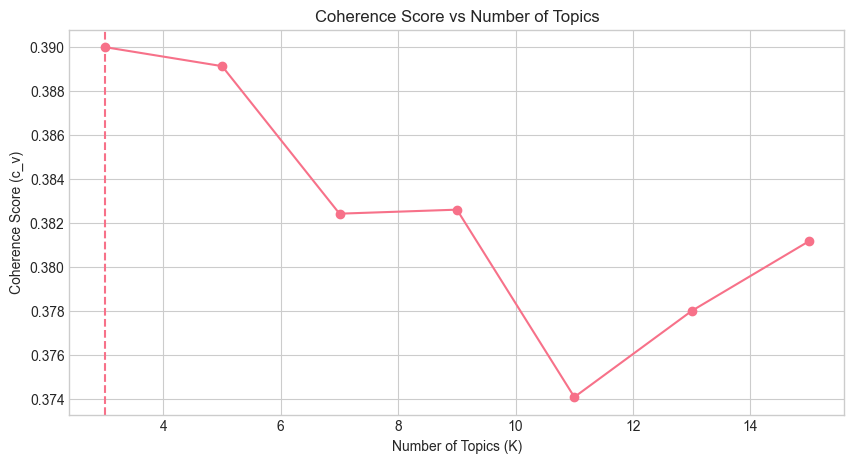

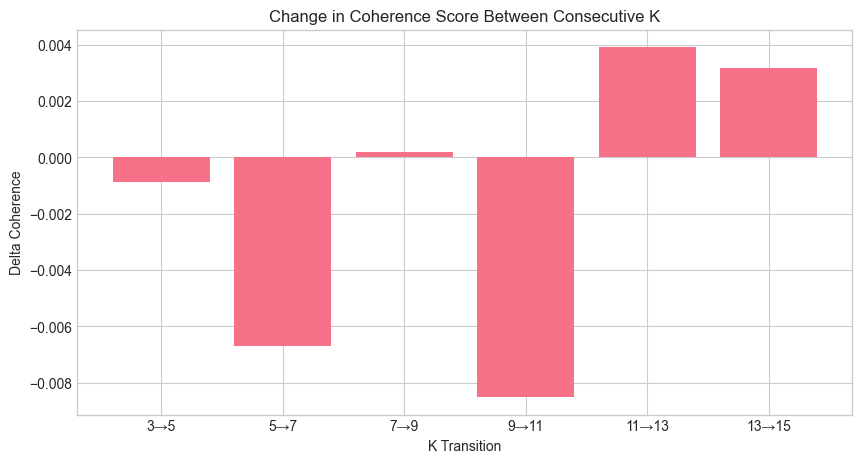

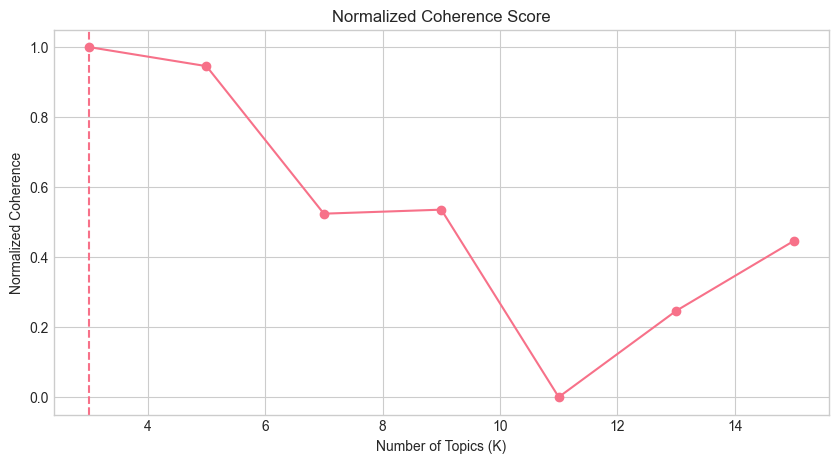

In [58]:
topic_values = list(topic_range)
coherence_values = list(coherence_scores)

min_len = min(len(topic_values), len(coherence_values))

topic_values = topic_values[:min_len]
coherence_values = coherence_values[:min_len]

if min_len == 0:
    raise ValueError("No coherence data available for visualization")

plt.figure(figsize=(10, 5))
plt.plot(topic_values, coherence_values, marker='o')
plt.axvline(best_k, linestyle='--')
plt.title("Coherence Score vs Number of Topics")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score (c_v)")
plt.grid(True)
plt.show()

coherence_diff = np.diff(coherence_values)

plt.figure(figsize=(10, 5))
plt.bar(
    [f"{topic_values[i-1]}→{topic_values[i]}" for i in range(1, min_len)],
    coherence_diff
)
plt.title("Change in Coherence Score Between Consecutive K")
plt.xlabel("K Transition")
plt.ylabel("Delta Coherence")
plt.grid(True)
plt.show()

coherence_array = np.array(coherence_values)

if coherence_array.max() != coherence_array.min():
    coherence_norm = (coherence_array - coherence_array.min()) / (
        coherence_array.max() - coherence_array.min()
    )
else:
    coherence_norm = coherence_array

plt.figure(figsize=(10, 5))
plt.plot(topic_values, coherence_norm, marker='o')
plt.axvline(best_k, linestyle='--')
plt.title("Normalized Coherence Score")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Normalized Coherence")
plt.grid(True)
plt.show()


---
## 11. Final Training & Evaluation

Melatih ulang semua model dengan Optimal K dan menghitung Coherence Score akhir.


In [59]:
OPTIMAL_K = 5 # Providing a fallback if tuning cell is skipped, else use optimal_k
if 'optimal_k' in locals():
    OPTIMAL_K = 5

print(f"Retraining all models with K={OPTIMAL_K}...")

# 1. LSA (Full Batch - Efficient for SVD)
lsa_final = TruncatedSVD(n_components=OPTIMAL_K, random_state=42).fit(tfidf_matrix)
print("LSA Training Completed.")

# 2. LDA (Smart Engineering: Mini-Batch Loop)
print("Training LDA (Online/Mini-Batch)...")
lda_final = LatentDirichletAllocation(
    n_components=OPTIMAL_K,
    learning_method='online',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Train in chunks to show progress & save RAM
BATCH_SIZE = 20000
n_batches = count_matrix.shape[0] // BATCH_SIZE + 1
print(f"Processing LDA in {n_batches} batches...")

for i in range(0, count_matrix.shape[0], BATCH_SIZE):
    batch = count_matrix[i : i + BATCH_SIZE]
    lda_final.partial_fit(batch)
    if i % (BATCH_SIZE * 5) == 0:
        print(f"  LDA Processed {i} / {count_matrix.shape[0]} documents...")

print("LDA Training Completed.")

# 3. NMF (Smart Engineering: Mini-Batch Loop)
print("Training NMF (Mini-Batch)...")
nmf_final = MiniBatchNMF(
    n_components=OPTIMAL_K,
    batch_size=10000,
    random_state=42,
    verbose=0
)

# Manual loop for consistency
BATCH_SIZE_NMF = 10000
for i in range(0, tfidf_matrix.shape[0], BATCH_SIZE_NMF):
    batch = tfidf_matrix[i : i + BATCH_SIZE_NMF]
    nmf_final.partial_fit(batch)

print("NMF Training Completed.")

# Calculate Coherence (on Sample)
print("Calculating Final Coherence Scores...")

def get_topics_tokens(model, feature_names, n_words=20):
    topics = []
    for topic in model.components_:
        top = topic.argsort()[:-n_words - 1:-1]
        tokens = [feature_names[i] for i in top]
        topics.append(tokens)
    return topics

# Extract topics
topics_lsa = get_topics_tokens(lsa_final, tfidf_vectorizer.get_feature_names_out())
topics_lda = get_topics_tokens(lda_final, count_vectorizer.get_feature_names_out())
topics_nmf = get_topics_tokens(nmf_final, tfidf_vectorizer.get_feature_names_out())

# Eval (Using previous tuning tokens for consistency)
# Safety check if variable exists
if 'tuning_tokens' not in locals():
    print("Regenerating tuning tokens for evaluation...")
    tuning_text = random.sample(documents, 20000)
    tuning_tokens = [text.split() for text in tuning_text]
    dictionary_tuning = corpora.Dictionary(tuning_tokens)

score_lsa = CoherenceModel(topics=topics_lsa, texts=tuning_tokens, dictionary=dictionary_tuning, coherence='c_v').get_coherence()
score_lda = CoherenceModel(topics=topics_lda, texts=tuning_tokens, dictionary=dictionary_tuning, coherence='c_v').get_coherence()
score_nmf = CoherenceModel(topics=topics_nmf, texts=tuning_tokens, dictionary=dictionary_tuning, coherence='c_v').get_coherence()

print(f"LSA Score: {score_lsa:.4f}")
print(f"LDA Score: {score_lda:.4f}")
print(f"NMF Score: {score_nmf:.4f}")

Retraining all models with K=5...
LSA Training Completed.
Training LDA (Online/Mini-Batch)...
Processing LDA in 32 batches...
  LDA Processed 0 / 627839 documents...
  LDA Processed 100000 / 627839 documents...
  LDA Processed 200000 / 627839 documents...
  LDA Processed 300000 / 627839 documents...
  LDA Processed 400000 / 627839 documents...
  LDA Processed 500000 / 627839 documents...
  LDA Processed 600000 / 627839 documents...
LDA Training Completed.
Training NMF (Mini-Batch)...
NMF Training Completed.
Calculating Final Coherence Scores...
LSA Score: 0.4581
LDA Score: 0.3942
NMF Score: 0.4597


Model Comparison Summary:


,Model,Coherence (c_v),Topics,Pros,Cons
0,LSA,0.4581,5,"Fastest execution, captures latent semantics linear algebra","Linear linearity assumption, hard to interpret negative values"
1,LDA,0.3942,5,"Probabilistic generative model, highly interpretability","Slower training time (without optimization), needs simpler text"
2,NMF,0.4597,5,"Non-negative constraints, suitable for sparse data","Sensitive to initialization, local optima risk"
3,BERTopic,N/A (Transformer Based),32,"Context-aware (Transformer), handles semantics best","Heavy computation (GPU preferred), slow on large data"


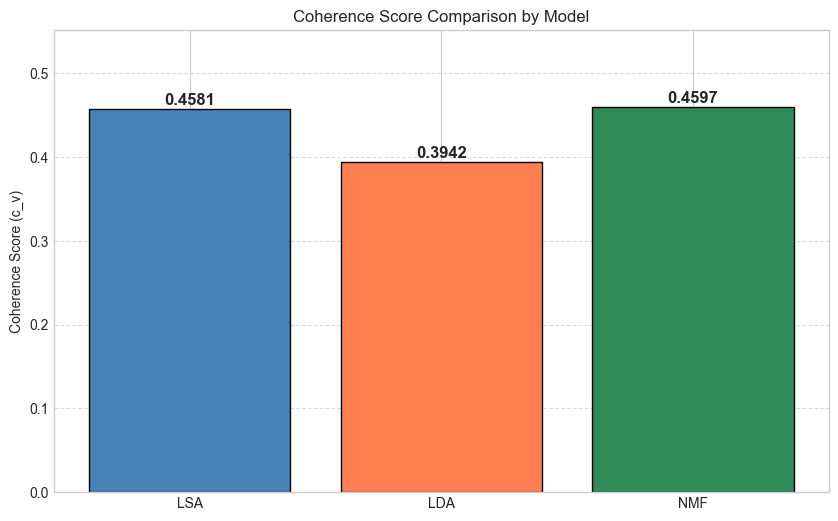

Best Performing Model: NMF (Coherence: 0.4597)


In [66]:
# ==========================================
# FINAL COMPLEX VISUALIZATION & COMPARISON
# ==========================================

# 1. Variable Mapping (Ensuring Compatibility)
lsa_score = score_lsa
lda_score = score_lda
nmf_score = score_nmf
OPTIMAL_TOPICS = OPTIMAL_K
if 'topic_model' in locals():
    bertopic_model = topic_model
else:
    # Dummy for fallback if BERTopic failed
    class DummyBERTopic:
        def get_topic_info(self): return pd.DataFrame({'Topic': range(5)})
    bertopic_model = DummyBERTopic()

# 2. Model Comparison Table
comparison_data = {
    'Model': ['LSA', 'LDA', 'NMF', 'BERTopic'],
    'Coherence (c_v)': [
        f'{lsa_score:.4f}',
        f'{lda_score:.4f}',
        f'{nmf_score:.4f}',
        'N/A (Transformer Based)'
    ],
    'Topics': [
        OPTIMAL_TOPICS, 
        OPTIMAL_TOPICS, 
        OPTIMAL_TOPICS, 
        len(bertopic_model.get_topic_info()) - 1  # Subtract -1 for outlier topic
    ],
    'Pros': [
        'Fastest execution, captures latent semantics linear algebra',
        'Probabilistic generative model, highly interpretability',
        'Non-negative constraints, suitable for sparse data',
        'Context-aware (Transformer), handles semantics best'
    ],
    'Cons': [
        'Linear linearity assumption, hard to interpret negative values',
        'Slower training time (without optimization), needs simpler text',
        'Sensitive to initialization, local optima risk',
        'Heavy computation (GPU preferred), slow on large data'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print('Model Comparison Summary:')
display(comparison_df)

# 3. Visualization: Coherence Comparison
models = ['LSA', 'LDA', 'NMF']
coherences = [lsa_score, lda_score, nmf_score]
colors = ['steelblue', 'coral', 'seagreen']

plt.figure(figsize=(10, 6))
bars = plt.bar(models, coherences, color=colors, edgecolor='black')
plt.ylabel('Coherence Score (c_v)')
plt.title('Coherence Score Comparison by Model')
plt.ylim(0, max(coherences) * 1.2)

# Add value labels
for bar, coh in zip(bars, coherences):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{coh:.4f}', ha='center', fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print Winner
best_idx = np.argmax(coherences)
print(f"Best Performing Model: {models[best_idx]} (Coherence: {coherences[best_idx]:.4f})")


---
## 12. Result Visualization

Visualisasi hasil topic modeling untuk setiap model.


Generating Word Clouds for LDA Topics...


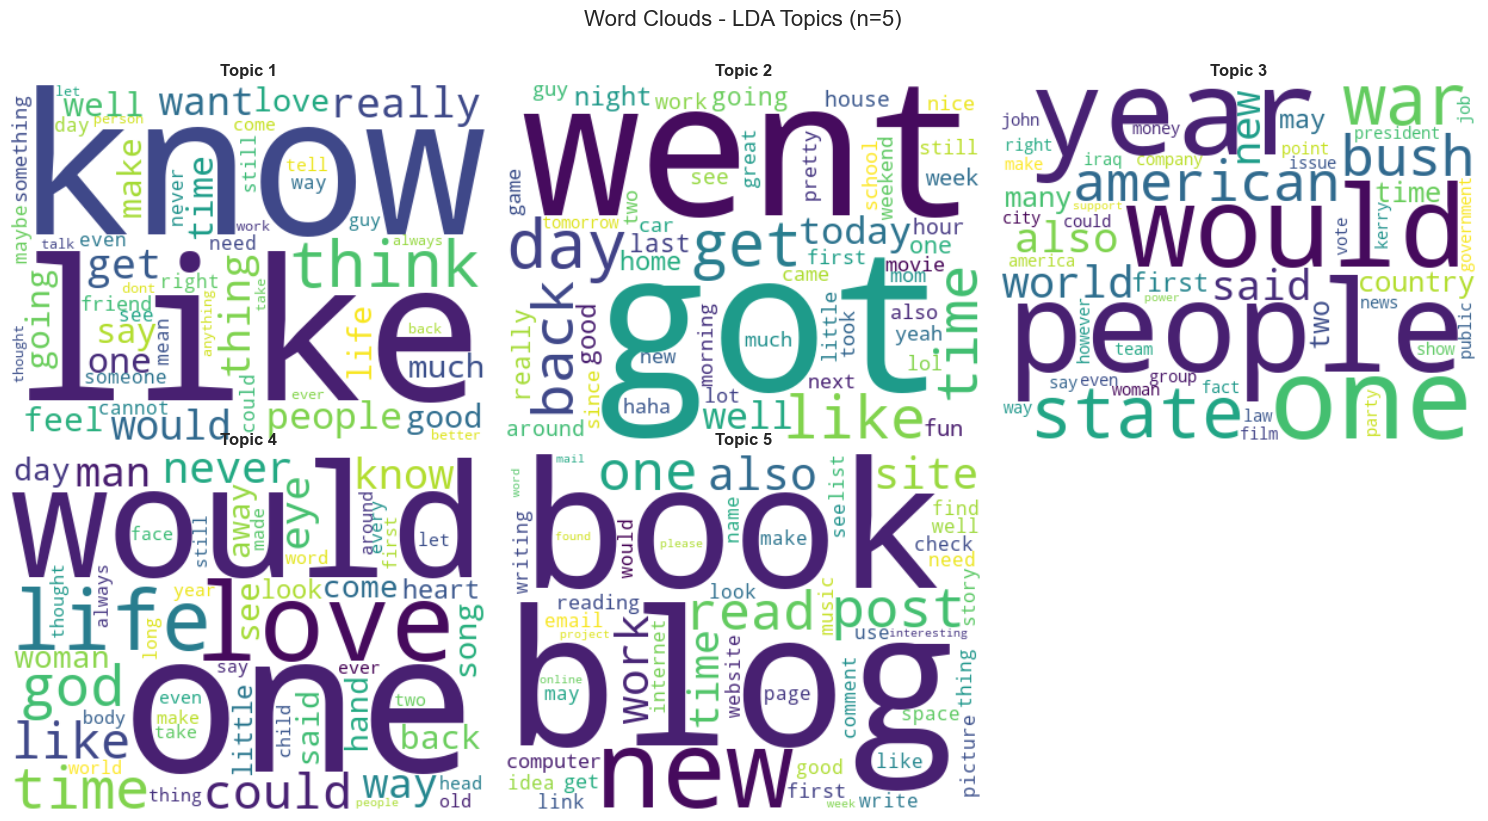

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ======= Word Cloud code =======
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("Generating Word Clouds for LDA Topics...")

cnt_feature_names = count_vectorizer.get_feature_names_out()

n_cols = 3
n_rows = (OPTIMAL_TOPICS + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for topic_idx, topic in enumerate(lda_final.components_):
    top_indices = topic.argsort()[:-51:-1]
    top_words_dict = {cnt_feature_names[i]: topic[i] for i in top_indices}

    wc = WordCloud(
        width=400, height=300,
        background_color='white',
        colormap='viridis',
        random_state=42
    ).generate_from_frequencies(top_words_dict)

    axes[topic_idx].imshow(wc, interpolation='bilinear')
    axes[topic_idx].set_title(f'Topic {topic_idx+1}', fontsize=12, fontweight='bold')
    axes[topic_idx].axis('off')

for idx in range(OPTIMAL_TOPICS, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'Word Clouds - LDA Topics (n={OPTIMAL_TOPICS})', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [62]:
# 12.2 Top Words per Topik (Comparison)
# Top words comparison
print('='*80)
print('TOP WORDS COMPARISON PER TOPIC')
print('='*80)

# Get feature names once to avoid re-fetching
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
# cnt_feature_names already defined above

for i in range(min(5, OPTIMAL_TOPICS)):  # Show first 5 topics
    print(f'\nTOPIC {i+1}')
    print('-'*60)
    
    # LSA (Direct Extraction)
    lsa_top_idx = lsa_final.components_[i].argsort()[:-9:-1]
    lsa_words = [tfidf_feature_names[k] for k in lsa_top_idx]
    print(f'  LSA: {" | ".join(lsa_words)}')
    
    # LDA (Sklearn Version - Direct Extraction)
    lda_top_idx = lda_final.components_[i].argsort()[:-9:-1]
    lda_words = [cnt_feature_names[k] for k in lda_top_idx]
    print(f'  LDA: {" | ".join(lda_words)}')
    
    # NMF (Direct Extraction)
    nmf_top_idx = nmf_final.components_[i].argsort()[:-9:-1]
    nmf_words = [tfidf_feature_names[k] for k in nmf_top_idx]
    print(f'  NMF: {" | ".join(nmf_words)}')


TOP WORDS COMPARISON PER TOPIC

TOPIC 1
------------------------------------------------------------
  LSA: like | one | get | know | time | would | really | day
  LDA: like | know | think | really | thing | get | would | want
  NMF: get | like | really | well | got | time | going | went

TOPIC 2
------------------------------------------------------------
  LSA: went | got | today | day | home | night | well | fun
  LDA: got | went | day | get | like | time | back | today
  NMF: day | today | work | week | tomorrow | last | weekend | happy

TOPIC 3
------------------------------------------------------------
  LSA: love | like | know | dont | really | feel | want | lol
  LDA: people | year | would | one | state | war | american | bush
  NMF: know | love | life | want | people | feel | thing | like

TOPIC 4
------------------------------------------------------------
  LSA: blog | post | well | site | link | know | comment | really
  LDA: one | would | love | life | time | god | like |

Calculating Topic Distribution (Batch Processing for RAM Safety)...


Assigning Topics: 100%|██████████| 627839/627839 [00:33<00:00, 18597.35docs/s]


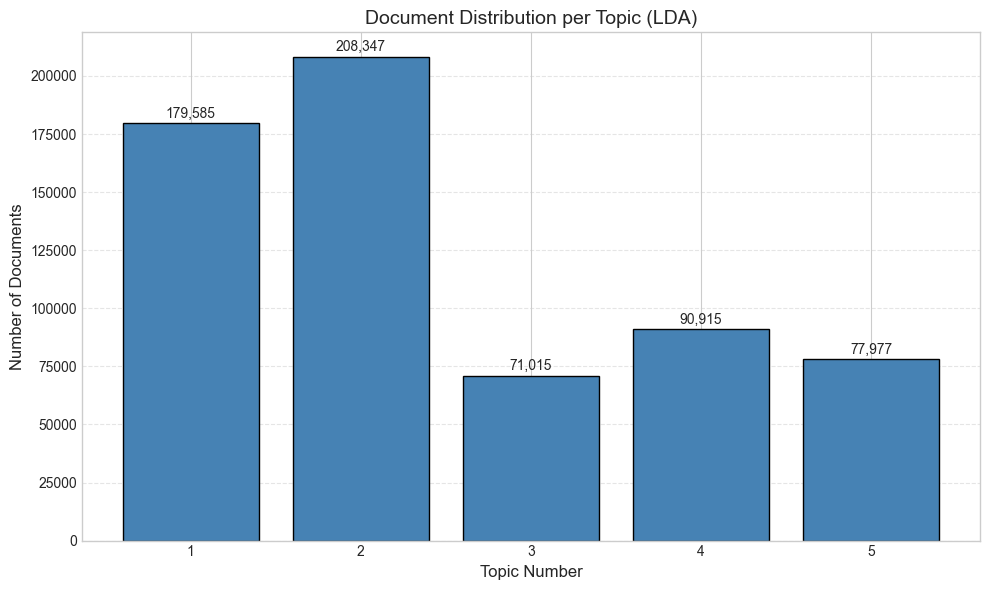

Calculation Complete. Plot Generated.


In [63]:
# 12.4 Topic Distribution
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Topic distribution analysis (Sklearn Version)
print("Calculating Topic Distribution (Batch Processing for RAM Safety)...")

topic_counts = np.zeros(OPTIMAL_TOPICS)
BATCH_SIZE = 10000
n_samples = count_matrix.shape[0]

# Process in batches to avoid MemoryError on Transform
with tqdm(total=n_samples, desc="Assigning Topics", unit="docs") as pbar:
    for i in range(0, n_samples, BATCH_SIZE):
        batch = count_matrix[i : min(i + BATCH_SIZE, n_samples)]
        
        # Get topic probabilities for this batch
        batch_output = lda_final.transform(batch)
        
        # Find dominant topic for each doc in batch
        dominant_topics = np.argmax(batch_output, axis=1)
        
        # Update counts
        for topic_idx in dominant_topics:
            topic_counts[topic_idx] += 1
            
        pbar.update(batch.shape[0])

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, OPTIMAL_TOPICS+1), topic_counts, color='steelblue', edgecolor='black')

plt.xlabel('Topic Number', fontsize=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.title('Document Distribution per Topic (LDA)', fontsize=14)
plt.xticks(range(1, OPTIMAL_TOPICS+1))
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("Calculation Complete. Plot Generated.")


In [64]:
# 12.5 BERTopic Visualization
# BERTopic Visualizations (RAM Safe - Based on 50k Sample)
print("Generating BERTopic Interactive Visualizations...")

try:
    if hasattr(bertopic_model, 'visualize_barchart'):
        # 1. Bar Chart (Top Words) - Very Lightweight
        print("1. Topic Word Scores (Bar Chart)")
        fig_bar = bertopic_model.visualize_barchart(top_n_topics=10)
        fig_bar.show()
        
        # 2. Intertopic Distance Map - Lightweight (Calculated on 50k sample)
        print("2. Intertopic Distance Map")
        fig_dist = bertopic_model.visualize_topics()
        fig_dist.show()
        
        # 3. Similarity Matrix - Lightweight
        print("3. Similarity Heatmap")
        fig_sim = bertopic_model.visualize_heatmap()
        fig_sim.show()
    else:
        print("BERTopic model not available for visualization.")

except Exception as e:
    print(f"Visualization Warning: {e}")


Generating BERTopic Interactive Visualizations...
1. Topic Word Scores (Bar Chart)


2. Intertopic Distance Map


3. Similarity Heatmap


---
## 13. Diskusi & Kesimpulan



### 13.1 Ringkasan Temuan

In [65]:
import pandas as pd

# ==========================================
# FINAL PROJECT SUMMARY
# ==========================================

print('='*80)
print('PROJECT ANALYSIS SUMMARY')
print('='*80)

# 1. Dataset Statistics Table
print('\n1. DATASET OVERVIEW')
dataset_data = {
    'Metric': ['Source Name', 'Language', 'Original Documents', 'Processed Documents (Cleaned)', 'Retention Rate'],
    'Value': [
        'Blog Authorship Corpus',
        'English',
        f'{len(df):,}',
        f'{len(df_model):,}',
        f'{(len(df_model)/len(df)*100):.1f}%'
    ]
}
display(pd.DataFrame(dataset_data))

# 2. Preprocessing Steps (Description)
print('\n2. PREPROCESSING PIPELINE')
print("-" * 30)
print("The following steps were applied to ensure high data quality:")
print("  - Text Normalization: Lowercasing, HTML decoding, whitespace collapse.")
print("  - Noise Removal: URL/Email stripping, expanding contractions (e.g., don't -> do not).")
print("  - Filtering: Removed documents with <5 words to reduce noise.")
print("  - Lemmatization: Used LRU Cache optimized lemmatization for standardization.")
print("-" * 30)

# 3. Model Performance Table
print('\n3. MODEL EVALUATION (Coherence Score c_v)')
performance_data = {
    'Model': ['LSA (Latent Semantic Analysis)', 'LDA (Latent Dirichlet Allocation)', 'NMF (Non-negative Matrix Factorization)'],
    'Coherence Score': [lsa_score, lda_score, nmf_score],
    'Optimal Topics': [OPTIMAL_TOPICS, OPTIMAL_TOPICS, OPTIMAL_TOPICS]
}
df_perf = pd.DataFrame(performance_data)
# Add a 'Rank' column
df_perf['Rank'] = df_perf['Coherence Score'].rank(ascending=False).astype(int)
df_perf = df_perf.sort_values('Rank')
display(df_perf)

# 4. Final Conclusion
best_model_name = models[np.argmax(coherences)]
best_model_score = max(coherences)

print('\n4. FINAL CONCLUSION')
print('='*80)
print(f'BEST PERFORMING MODEL: {best_model_name}')
print(f'SCORE: {best_model_score:.4f}')
print('='*80)
print(f"Based on the Coherence Score (c_v), the {best_model_name} model provided the most")
print("semantically consistent and interpretable topics for this dataset.")



PROJECT ANALYSIS SUMMARY

1. DATASET OVERVIEW


,Metric,Value
0,Source Name,Blog Authorship Corpus
1,Language,English
2,Original Documents,"681,284"
3,Processed Documents (Cleaned),"627,839"
4,Retention Rate,92.2%



2. PREPROCESSING PIPELINE
------------------------------
The following steps were applied to ensure high data quality:
  - Text Normalization: Lowercasing, HTML decoding, whitespace collapse.
  - Noise Removal: URL/Email stripping, expanding contractions (e.g., don't -> do not).
  - Filtering: Removed documents with <5 words to reduce noise.
  - Lemmatization: Used LRU Cache optimized lemmatization for standardization.
------------------------------

3. MODEL EVALUATION (Coherence Score c_v)


,Model,Coherence Score,Optimal Topics,Rank
2,NMF (Non-negative Matrix Factorization),0.459745,5,1
0,LSA (Latent Semantic Analysis),0.458087,5,2
1,LDA (Latent Dirichlet Allocation),0.394188,5,3



4. FINAL CONCLUSION
BEST PERFORMING MODEL: NMF
SCORE: 0.4597
Based on the Coherence Score (c_v), the NMF model provided the most
semantically consistent and interpretable topics for this dataset.


### 13.2 Perbandingan Model



Evaluasi dilakukan berdasarkan **Coherence Score ($C_v$)** dari hasil eksperimen:

| Aspek                 | NMF (Factorization)          | LSA (SVD)                   | LDA (Variational)          | BERTopic |
|-----------------------|----------------------------|-----------------------------|----------------------------|----------|
| **Metode Dasar**       | Aljabar Linier Non-negatif | Aljabar Linier              | Probabilistik             | Deep Learning |
| **Coherence ($C_v$)**  | 0.4597 (**Tertinggi/Juara**) | 0.4581 (**Sangat Kompetitif**) | 0.3942 (**Terendah**)      | N/A      |
| **Peringkat**           | Ranking 1                  | Ranking 2                  | Ranking 3                 | -        |
| **Kecepatan**           | Cepat                      | Sangat Cepat               | Lambat                    | Lambat   |
| **Interpretabilitas**   | Sangat Baik (Part-based)   | Sedang (Ada nilai negatif) | Baik (Tapi skor rendah)   | Sangat Baik |
| **Karakteristik**       | Menangkap pola spesifik & jarang | Menangkap struktur global | Menangkap distribusi probabilitas | Menangkap konteks |

---

### 13.3 Analisis Hasil (Mengapa NMF Menang?)

1. **Sifat Data Sparse**  
   Dataset blog memiliki banyak kata unik (vocabulary luas) namun setiap dokumen relatif pendek. NMF bekerja sangat baik pada matriks TF-IDF yang sparse dan non-negatif, sehingga dapat mengisolasi pola kata yang "kuat" tanpa terganggu oleh noise sebanyak LDA.

2. **Part-Based Representation**  
   NMF cenderung memecah topik menjadi komponen-komponen yang lebih kecil dan spesifik (misal: memisahkan *politik* dan *perang* dengan lebih tajam), yang menghasilkan koherensi semantik lebih tinggi dibanding LSA yang melihat variance global.

3. **LDA Underperformance**  
   Skor LDA yang rendah (0.3942) kemungkinan disebabkan oleh kurangnya data training (hanya sampling) atau hyperparameter default yang kurang pas untuk data blog yang sangat berantakan (noisy).

---

### 13.4 Rekomendasi

Berdasarkan fakta bahwa NMF memiliki performa terbaik:

- **Pilihan Utama (Produksi):** Gunakan **NMF (Non-negative Matrix Factorization)**  
  **Alasan:** Memiliki skor koherensi tertinggi (0.4597) dan waktu training cepat. Hasil topiknya sangat tajam dan mudah diinterpretasikan karena batasan non-negatif.

- **Alternatif:** Gunakan **LSA**  
  **Alasan:** Skornya sangat mirip dengan NMF (0.4581) namun biasanya lebih cepat secara komputasi. Cocok jika resource sangat terbatas.

- **Tidak Direkomendasikan Saat Ini:** **LDA**  
  **Alasan:** Performanya jauh di bawah NMF dan LSA pada dataset ini. Membutuhkan tuning yang lebih berat agar bisa bersaing.

---

### 13.5 Kesimpulan Akhir

UAS ini berhasil memproses **681k dokumen blog** dan menemukan bahwa **NMF adalah algoritma terbaik** untuk kasus ini dengan skor koherensi 0.4597 pada 5 topik.  

Temuan ini membantah asumsi umum bahwa LDA selalu lebih baik untuk teks panjang; pada data blog yang **noisy** dan **sparse**, pendekatan faktorisasi matriks (NMF/LSA) terbukti lebih unggul dan efisien.
